In [24]:
import json
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [25]:
keyNamePath='data/key_name.csv'
keyTestTConfigPath='data/key_test_t_config.csv'
keyTestTScenesPath='data/key_test_t_scenes.csv'
# keyTestTPath='data/key_test_t.csv'
keyTestTPath='backup/forTest/keyTestT.csv'

In [26]:
keyTestT = pd.read_csv(keyTestTPath, usecols=['dimension', 'results'])

In [27]:
keyTestT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   results    50 non-null     object
 1   dimension  50 non-null     object
dtypes: object(2)
memory usage: 928.0+ bytes


In [28]:
keyTestT.head()

,results,dimension
0,"{""#wrk_qps_avg"": 1547599.39, ""wrk_latency_avg""...","{""cvm_cpu"": ""62"", ""platform"": ""qcloud"", ""test_..."
1,"{""openssl_des_size_16"": 27246690.0, ""openssl_d...","{""cvm_cpu"": ""32"", ""platform"": ""qcloud"", ""test_..."
2,"{""#ls_time"": 18}","{""dd"": ""name_11"", ""cvm_cpu"": ""1"", ""platform"": ..."
3,"{""#ls_time"": 18}","{""dd"": ""name_11"", ""cvm_cpu"": ""1"", ""platform"": ..."
4,"{""#mlc_idle_latency"": 90.6}","{""cvm_cpu"": ""8"", ""platform"": ""default"", ""test_..."


In [29]:
# 打印数组的前三个元素
def showVec(outputRes,num=3):
    for i in range(len(outputRes)):
        if i<num:
            print(outputRes[i])
        else:
            break

def showDict(dict,num=3):
    # 打印字典的前三个元素
    for i, (key, value) in enumerate(dict.items()):
        if i<num:
            print(f"{key}: {value}")
        else:
            break

# 获得所有的key
def getAllKeys(inputJson):
    for key in inputJson:
        if isinstance(inputJson[key], dict):
            getAllKeys(inputJson[key])  # 递归调用
        else:
            return key

In [30]:
def getResultArgList(resultArgList):
    # 解析results列的json数据，将每个json数据中带有#的数据提取出来，放入inputlist中，使用tqdm显示进度条
    errornum = 0
    for index, row in tqdm.tqdm(keyTestT.iterrows(), total=keyTestT.shape[0]):
        result = row['results']
        try:
            resultJson = json.loads(result)
            for key in resultJson:
                if key.find('#') != -1:
                    resultArgList.append(key)
        except:
            errornum += 1

    print('json解析错误的数量：', errornum)
    # 去重
    resultArgList = list(set(resultArgList))
    # 指标个数
    print('指标个数：', len(resultArgList))
    # 打印前五个指标
    print('前五个指标：', resultArgList[:5])
    return resultArgList

def getOutput(keyTestT, column, inputStandardDict):
    # 获得keyTestT中的results列的json数据
    errornum = 0
    res=[]
    for index, row in tqdm.tqdm(keyTestT.iterrows(), total=keyTestT.shape[0]):
        data = row[column]
        resDict = inputStandardDict.copy()
        try:
            jsonData = json.loads(data)
            for key in resDict.keys():
                if key in jsonData:
                    # 判断jsonData[key]是否为合法数字，若是合法数字，则将其赋值给resDict[key]
                    if isinstance(jsonData[key], (int, float)):
                        resDict[key] = float(jsonData[key])
        except:
            errornum += 1
        # 将resDict中所有的value值提取出来，放入resFeature中
        resFeature = list(resDict.values())
        res.append(resFeature)
    print('json解析错误的数量：', errornum)
    res=np.array(res)
    return res

def getInputFeature(keyTestT):
    errornum = 0
    # 指定需要提取的字段
    res=[]
    keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
    for index, row in tqdm.tqdm(keyTestT.iterrows(), total=keyTestT.shape[0]):
        dimension = row['dimension']
        # templist=[]
        templist=['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
        try:
            dimensionJson = json.loads(dimension)
            for key in dimensionJson:
                if key in keys_to_extract:  # 判断该字段是否需要提取
                    if isinstance(dimensionJson[key], dict):
                        key_value = getAllKeys(dimensionJson[key])
                    else:
                        key_value = dimensionJson[key]
                    if key=='cvm_memory':
                        key_value=float(key_value.split(' ')[0])
                    elif key=='cvm_cpu':
                        key_value=float(key_value)
                    elif key=='cvm_cpu_qos':
                        key_value=1.0
                    templist[keys_to_extract.index(key)]=key_value
            res.append(templist)
        except:
            errornum += 1
    print('json解析错误的数量：', errornum)
    return res

def getInput(inputDim):
    labelencoder = LabelEncoder()
    onehotencoder = OneHotEncoder()
    data = np.array(inputDim)[:, :4]
    encoders = []
    for i in range(data.shape[1]):
        encoder = LabelEncoder()
        encoder.fit(data[:, i])
        data[:, i] = encoder.transform(data[:, i])
        encoders.append(encoder)

    data = data.astype(float)
    return data

In [31]:
resultArgList=[]
dimensionArgList=[]

In [32]:
resultArgList = getResultArgList(resultArgList)

100%|██████████| 50/50 [00:00<00:00, 1612.92it/s]

json解析错误的数量： 0
指标个数： 69
前五个指标： ['#pgbench_SELECT_ONLY', '#openssl_rsa_size_1024_verify', '#openssl_rsa_size_2048_verify', '#ls_time', '#tcpping_distribution_999']


In [33]:
# 将resultArgList列表转换为字典，key为指标名称，value为0
resDict = dict(zip(resultArgList, [0] * len(resultArgList)))
showDict(resDict)

#pgbench_SELECT_ONLY: 0
#openssl_rsa_size_1024_verify: 0
#openssl_rsa_size_2048_verify: 0


In [34]:
output=getOutput(keyTestT, 'results', resDict)

100%|██████████| 50/50 [00:00<00:00, 2631.24it/s]

json解析错误的数量： 0


In [35]:
print(output.shape)
showVec(output,5)

(50, 69)
[      0.         0.         0.         0.         0.         0.
       0.         0.         0.         0.         0.         0.
       0.         0.         0.         0.         0.         0.
       0.         0.         0.         0.         0.         0.
       0.         0.         0.         0.         0.         0.
       0.         0.         0.         0.         0.         0.
 1547599.39       0.         0.         0.         0.         0.
       0.         0.         0.         0.         0.         0.
       0.         0.         0.         0.         0.         0.
       0.         0.         0.         0.         0.         0.
       0.         0.         0.         0.         0.         0.
       0.         0.         0.  ]
[0.00000000e+00 1.69156800e+05 5.38582000e+04 0.00000000e+00
 0.00000000e+00 2.50346500e+07 1.86794640e+08 0.00000000e+00
 1.69255520e+08 0.00000000e+00 6.88029040e+08 0.00000000e+00
 1.56977930e+08 6.40550830e+08 1.69277510e+08 0.00000000e+

In [36]:
inputDim = getInputFeature(keyTestT)

100%|██████████| 50/50 [00:00<00:00, 2941.14it/s]

json解析错误的数量： 0


In [37]:
input=getInput(inputDim)

In [38]:
print(input.shape)
showVec(input,5)

(50, 4)
[7. 4. 0. 4.]
[ 4. 10.  0.  4.]
[0. 2. 1. 8.]
[0. 2. 1. 8.]
[9. 0. 1. 0.]


In [39]:
import torch
from torch.utils.data import Dataset, DataLoader

# 定义数据集类
class MyDataset(Dataset):
    def __init__(self, input, output):
        self.input = input
        self.output = output
        
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.input[idx], dtype=torch.float32)
        y = torch.tensor(self.output[idx], dtype=torch.float32)
        return x, y

# 定义模型类
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = torch.nn.Linear(4, 32)
        self.fc2 = torch.nn.Linear(32, 69)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
# 将数据集和模型放入GPU
model = MyModel().to(device)

# 将input和output放在device中
inputs = torch.tensor(input).to(device)
outputs = torch.tensor(output).to(device)

# 创建数据集和数据加载器
dataset = MyDataset(input, output)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [57]:
# 损失函数
criterion = torch.nn.MSELoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [62]:
# 定义空列表存储每个epoch的损失和准确率
train_loss = []
train_acc = []

In [60]:
def train(epoch):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch: {}, Loss: {:.6f}'.format(epoch, running_loss / len(dataloader)))
    train_loss.append(running_loss / len(dataloader))

In [61]:
# train(10)

Epoch: 10, Loss: 292783689877351995308475208957952.000000


In [74]:
numEpoch = 10000

Epoch 1 loss: 44056786172773165694976.000
Epoch 1001 loss: 4333198909853514334208.000
Epoch 2001 loss: 426191631775746293760.000
Epoch 3001 loss: 41918901567739535360.000
Epoch 4001 loss: 4123907388012935168.000
Epoch 5001 loss: 406583270115985344.000
Epoch 6001 loss: 40968062323361056.000
Epoch 7001 loss: 5007289340028518.000
Epoch 8001 loss: 1470440293542133.750
Epoch 9001 loss: 1122616146646794.250


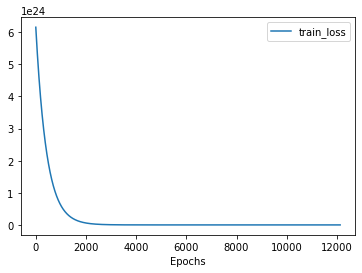

In [75]:
for epoch in range(numEpoch):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 统计损失和准确率
        running_loss += loss.item()
        total += labels.size(0)
    
    # 计算每个epoch的平均损失和准确率
    epoch_loss = running_loss/len(dataset)
    train_loss.append(epoch_loss)

    if epoch % 1000 == 0:
        print('Epoch %d loss: %.3f' % (epoch+1, epoch_loss))

# 绘制损失和准确率曲线
plt.plot(range(len(train_loss)), train_loss, label='train_loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 待研究

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 69)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# 准备数据
input = torch.tensor(np.random.rand(50, 4)).float()
output = torch.tensor(np.random.rand(50, 69)).float()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 10
losses = []
accuracies = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i in range(len(input)):
        inputs, labels = input[i], output[i]
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(0))
        loss = criterion(outputs, labels.unsqueeze(0))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(input)
    epoch_accuracy = 100.0 * correct / total
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
    print('Epoch %d loss: %.3f accuracy: %.3f' % (epoch+1, epoch_loss, epoch_accuracy))

# 绘制图表
plt.plot(losses, label='Loss')
plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.show()
